In [ ]:
import os
cd = os.getcwd()
print(cd)

from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np

/content
Mounted at /content/gdrive


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import *
import torch.optim as optim

# Load data

In [ ]:
path = '/content/gdrive/My Drive/Colab Notebooks/SPH6004/TeamShare/ProcessedData/train/'

static = pd.read_csv(path+'flat.csv',index_col='patient')

dynamic = pd.read_csv(path+'timeseries.csv',index_col='patient')

labels = pd.read_csv(path+'labels.csv',index_col='patient')

tfid_df = pd.read_csv(path+'tfid_dataframe.csv',index_col='patient')

In [ ]:
def add_padding(df,time_col,groupby_col):
    # Convert 'time_col' to integer for correct sequence generation
    df[time_col] = df[time_col].astype(int)

    # Define a function to add missing rows for each group
    def add_missing(group):
        # Generate the complete sequence of 'time_slot' for the group
          complete_sequence = pd.Series(range(1, 5))
          group_cp = group.set_index(time_col).reindex(complete_sequence).reset_index().fillna(0)
          return group_cp

    resampled = df.groupby(groupby_col).apply(add_missing).reset_index(level=1).drop(columns='level_1')
    resampled.drop(columns='patient', inplace=True)
    resampled.rename(columns={'index': 'time_slot'}, inplace=True)

    # Apply the function to each group and concatenate the results
    return resampled

dyn_reset = dynamic.reset_index()
padded_timeseries = add_padding(dyn_reset,'time_slot','patient')



---
# Multi modal LSTM


---




In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

y = np.array(labels['los_icu']).reshape(-1,1)

mm = MinMaxScaler()
y_mm = mm.fit_transform(y)

from torch.autograd import Variable
y_tensors = Variable(torch.Tensor(y_mm))

In [ ]:
X_ts = padded_timeseries.drop(columns='time_slot')
sequence_length = 4
input_features = X_ts.shape[1]
timeseries_tensor = torch.Tensor(np.array(X_ts)).view(-1, sequence_length, input_features)

static_cat_tensor = torch.Tensor(np.array(static.drop(columns=static.columns[range(1,5)])))
static_val_tensor = torch.Tensor(np.array(static.iloc[:,range(1,5)] ))

tfid_tensor = torch.Tensor(np.array(tfid_df))

# checking the size of data
print('Shapes:',y_tensors.shape, timeseries_tensor.shape,static_cat_tensor.shape,static_val_tensor.shape,tfid_tensor.shape)

Shapes: torch.Size([12077, 1]) torch.Size([12077, 4, 18]) torch.Size([12077, 27]) torch.Size([12077, 4]) torch.Size([12077, 100])


In [ ]:
class FusionLSTM(nn.Module):
        def __init__(self, args):
            super(FusionLSTM, self).__init__()
            self.args = args

            #static
            self.static_embedding = nn.Embedding(args.static_cat_input, args.embed_size)
            self.static_linear = nn.Linear(args.static_val_input, args.embed_size)
            self.static_mapping = nn.Sequential(
                    nn.Linear ( args.embed_size, args.embed_size),
                    nn.ReLU ( ),
                    nn.Dropout(0.1),
                    nn.Linear ( args.embed_size, args.embed_size),
                    nn.ReLU ( ),
                    nn.Dropout(0.1),
                    )

            #dynamic
            self.lstm = nn.LSTM (input_size=args.dynamic_input,
                                  hidden_size=args.hidden_size,
                                  num_layers=args.num_layers,
                                  batch_first=True,
                                  bidirectional=True)

            lstm_size = args.embed_size

            lstm_size *= 2

            self.lstm_mapping = nn.Sequential (
                nn.Linear (lstm_size, args.embed_size),
                nn.ReLU ( ),
                nn.Linear (args.embed_size, args.embed_size),
                nn.ReLU ( )
            )


            #text tfid
            self.text_linear = nn.Linear(args.text_input, args.embed_size)
            self.text_mapping = nn.Sequential(
                    nn.Linear ( args.embed_size, args.embed_size),
                    nn.ReLU ( ),
                    nn.Dropout(0.1),
                    nn.Linear ( args.embed_size, args.embed_size),
                    nn.ReLU ( ),
                    nn.Dropout(0.1),
                    )

            #common
            self.pooling = nn.AdaptiveMaxPool1d(1)
            self.relu = nn.ReLU ( )

            #final output
            self.cat_output = nn.Sequential (
                        nn.Linear (args.embed_size * 4, args.embed_size),
                        nn.ReLU ( ),
                        nn.Dropout ( 0.1),
                        nn.Linear ( args.embed_size, args.output_size),

                    )


        def forward(self, static_cat, static_val, dynamic, text):

          #static
          dsize_cat = list(static_cat.size()) + [-1]
          out_flat_cat = self.static_embedding(static_cat.type(torch.LongTensor).reshape(-1)).reshape(dsize_cat)
          out_flat_cat = self.static_mapping(out_flat_cat)
          out_flat_cat = torch.transpose(out_flat_cat, 1,2).contiguous()
          out_flat_cat = self.pooling(out_flat_cat)
          out_flat_cat = out_flat_cat.view((out_flat_cat.size(0), -1))

          out_flat_val = self.static_linear(static_val)
          out_flat_val = self.static_mapping(out_flat_val)
          out_flat_val = out_flat_val.unsqueeze(-1)
          out_flat_val = self.pooling(out_flat_val)
          out_flat_val = out_flat_val.view((out_flat_val.size(0), -1))

          #text
          #print("Running for text tfid")
          out_text = self.text_linear(text)
          out_text = self.text_mapping(out_text)
          out_text = out_text.unsqueeze(-1)
          out_text = self.pooling(out_text)
          out_text = out_text.view((out_text.size(0), -1))


          #lstm
          out_lstm, _ = self.lstm(dynamic)
          out_lstm = self.lstm_mapping(out_lstm)
          out_lstm = torch.transpose(out_lstm, 1,2).contiguous()
          out_lstm = self.pooling(out_lstm)
          out_lstm = out_lstm.view((out_lstm.size(0), -1))



          output = self.cat_output(torch.cat((out_lstm, out_text, out_flat_val,out_flat_cat), 1))

          return output




In [ ]:
import argparse

# Define the argument parser
parser = argparse.ArgumentParser(description='Argument parser for FusionLSTM model')

# Add arguments
#parser.add_argument('--static_input', type=int, help='static data input size')
parser.add_argument('--static_cat_input', type=int, help='static cat data input size')
parser.add_argument('--static_val_input', type=int, help='static value data input size')
parser.add_argument('--text_input', type=int, help='text data input size')
parser.add_argument('--dynamic_input', type=int, help='dynamic data input size')
parser.add_argument('--embed_size', type=int, help='embedding/ rnn size')
parser.add_argument('--hidden_size', type=int, help='hidden size for lstm')
parser.add_argument('--num_layers', type=int, default=1, help='num of layers in lstm')
parser.add_argument('--output_size', type=int, default=1, help='output size for all')

# Parse the arguments
args = parser.parse_args(args=[])

# Print the arguments
print(args)

Namespace(static_cat_input=None, static_val_input=None, text_input=None, dynamic_input=None, embed_size=None, hidden_size=None, num_layers=1, output_size=1)


In [ ]:
#args.static_input = static_tensor.shape[1]
args.static_cat_input = 27
args.static_val_input = 4
args.dynamic_input = timeseries_tensor.shape[2]
args.text_input = tfid_tensor.shape[1]

args.embed_size = args.hidden_size  = 256


args.num_layers = 2

print(args)

Namespace(static_cat_input=27, static_val_input=4, text_input=100, dynamic_input=18, embed_size=256, hidden_size=256, num_layers=2, output_size=1)


In [ ]:
lr = .000001

lstm_model = FusionLSTM(args) #our lstm class

criterion = nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)

print(lstm_model)

FusionLSTM(
  (static_embedding): Embedding(27, 256)
  (static_linear): Linear(in_features=4, out_features=256, bias=True)
  (static_mapping): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
  )
  (lstm): LSTM(18, 256, num_layers=2, batch_first=True, bidirectional=True)
  (lstm_mapping): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (text_linear): Linear(in_features=100, out_features=256, bias=True)
  (text_mapping): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
  )
  (

In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, targets, static_data_cat, static_data_val, time_series_data, text_tfid):
        self.time_series_data = time_series_data
        self.static_data_cat = static_data_cat
        self.static_data_val = static_data_val
        self.text_tfid = text_tfid
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        x_ts = self.time_series_data[idx]
        x_flat_cat = self.static_data_cat[idx]
        x_flat_val = self.static_data_val[idx]
        y_lab = self.targets[idx]
        x_text = self.text_tfid[idx]
        return y_lab, x_flat_cat, x_flat_val, x_ts, x_text

In [ ]:
from torch.utils.data import DataLoader
batch_size = 64

# Create data loader
dataset = CustomDataset(y_tensors, static_cat_tensor, static_val_tensor, timeseries_tensor,tfid_tensor )
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
n_epochs = 50

for epoch in range(n_epochs):
    sum_training_loss = 0

    for batch_idx, (y_lab, x_flat_cat, x_flat_val, x_time, x_tfid) in enumerate(data_loader):
        # x_time: Batch of time series data (shape: [batch_size, sequence_length, input_size])
        # y: Batch of target values (shape: [batch_size, output_size])
        # Pass data through the model
          output_los = lstm_model.forward(x_flat_cat, x_flat_val, x_time, x_tfid)


        # Calculate loss and update model parameters
          loss = criterion(output_los, y_lab)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          sum_training_loss += loss

    epoch_loss = sum_training_loss / len(train_loader)

    if epoch % 2 == 0 or epoch % 49 == 0:
          print("Epoch: %d, loss: %1.5f" % (epoch,epoch_loss ))

In [ ]:
# #to save
PATH = '/content/gdrive/My Drive/Colab Notebooks/SPH6004/fusionlstm.pt'
torch.save(lstm_model, PATH)

# #to load
# model = torch.load(PATH)
# model.eval()

In [ ]:
# training set predicion
with torch.no_grad():
  lstm_model.eval()
  train_predict = lstm_model(static_cat_tensor, static_val_tensor,timeseries_tensor,tfid_tensor)#forward pass


In [ ]:
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y_tensors.data.numpy()
data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

Text(0.5, 1.0, 'Training prediction')

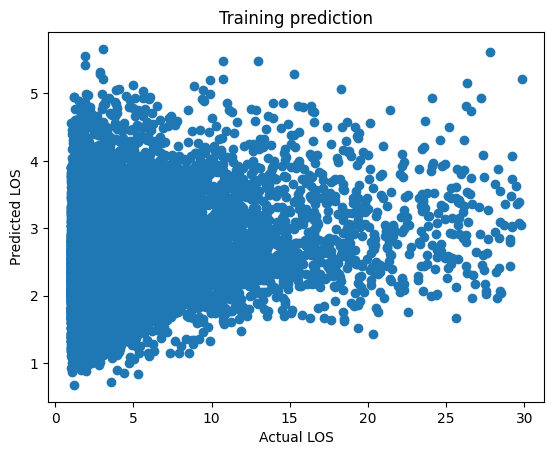

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x=dataY_plot, y=data_predict) #actual plot
plt.ylabel("Predicted LOS")
plt.xlabel("Actual LOS")
plt.title("Training prediction")
#plt.plot(, label='Predicted Data') #predicted plot
#plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(dataY_plot, data_predict)

mae = mean_absolute_error(dataY_plot, data_predict)

print("mse: %1.5f, mae: %1.5f" % (mse, mae))

mse: 22.66488, mae: 2.66207


## Test set prediction

In [ ]:
path = '/content/gdrive/My Drive/Colab Notebooks/SPH6004/TeamShare/ProcessedData/test/'

dynamic_test = pd.read_csv(path+'timeseries.csv',index_col='patient')
labels_test = pd.read_csv(path+'labels.csv',index_col='patient')
static_test = pd.read_csv(path+'flat.csv',index_col='patient')
tfid_test = pd.read_csv(path+'tfid_dataframe.csv',index_col='patient')

In [ ]:
y_test = np.array(labels_test['los_icu']).reshape(-1,1)
mm = MinMaxScaler()
y_mm_test = mm.fit_transform(y_test)
y_tensors_test = Variable(torch.Tensor(y_mm_test))

In [ ]:
padded_test = add_padding(dynamic_test.reset_index(),'time_slot','patient')

sequence_length = 4
input_features = 18
timeseries_tensors_test = torch.Tensor(np.array(padded_test.drop(columns='time_slot'))).view(-1, sequence_length, input_features)

static_cat_tensor_test = torch.Tensor(np.array(static_test.drop(columns=static.columns[range(1,5)])))
static_val_tensor_test = torch.Tensor(np.array(static_test.iloc[:,range(1,5)] ))

tfid_tensor_test = torch.Tensor(np.array(tfid_test))


# checking the size of data
print('Shapes:',y_tensors_test.shape, timeseries_tensors_test.shape,static_cat_tensor_test.shape, static_val_tensor_test.shape, tfid_tensor_test.shape)


Shapes: torch.Size([2589, 1]) torch.Size([2589, 4, 18]) torch.Size([2589, 27]) torch.Size([2589, 4]) torch.Size([2589, 100])


In [ ]:
with torch.no_grad():
  lstm_model.eval()
  test_predict = lstm_model(static_cat_tensor_test, static_val_tensor_test, timeseries_tensors_test,tfid_tensor_test)#forward pass

data_predict = test_predict.data.numpy() #numpy conversion
dataY_plot = y_tensors_test.data.numpy()

In [ ]:
data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

Text(0.5, 1.0, 'Validation set prediction')

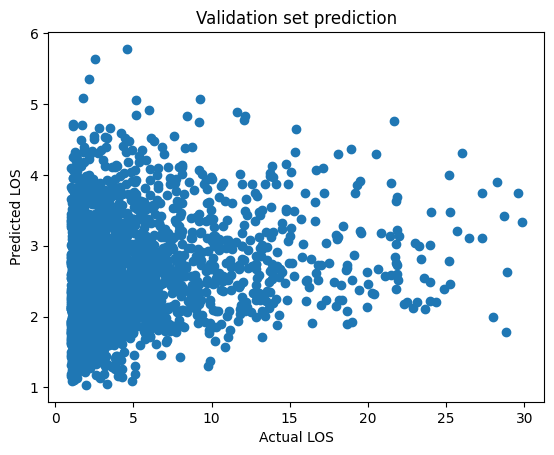

In [ ]:
plt.scatter(x=dataY_plot, y=data_predict) #actual plot
plt.ylabel("Predicted LOS")
plt.xlabel("Actual LOS")
plt.title('Validation set prediction')

In [ ]:
mse = mean_squared_error(dataY_plot, data_predict)

mae = mean_absolute_error(dataY_plot, data_predict)

print("mse: %1.5f, mae: %1.5f" % (mse, mae))

mse: 23.66353, mae: 2.70569


# Multitask

In [ ]:


class MultitaskLSTM(nn.Module):
        def __init__(self, args):
            super(MultitaskLSTM, self).__init__()
            self.args = args

            #static
            self.static_embedding = nn.Embedding(args.static_cat_input, args.embed_size)
            self.static_linear = nn.Linear(args.static_val_input, args.embed_size)
            self.static_mapping = nn.Sequential(
                    nn.Linear ( args.embed_size, args.embed_size),
                    nn.ReLU ( ),
                    nn.Dropout(0.1),
                    nn.Linear ( args.embed_size, args.embed_size),
                    nn.ReLU ( ),
                    nn.Dropout(0.1),
                    )

            #dynamic
            self.lstm = nn.LSTM (input_size=args.dynamic_input,
                                  hidden_size=args.hidden_size,
                                  num_layers=args.num_layers,
                                  batch_first=True,
                                  bidirectional=True)

            lstm_size = args.embed_size

            lstm_size *= 2

            self.lstm_mapping = nn.Sequential (
                nn.Linear (lstm_size, args.embed_size),
                nn.ReLU ( ),
                nn.Linear (args.embed_size, args.embed_size),
                nn.ReLU ( )
            )


            #text tfid
            self.text_linear = nn.Linear(args.text_input, args.embed_size)
            self.text_mapping = nn.Sequential(
                    nn.Linear ( args.embed_size, args.embed_size),
                    nn.ReLU ( ),
                    nn.Dropout(0.1),
                    nn.Linear ( args.embed_size, args.embed_size),
                    nn.ReLU ( ),
                    nn.Dropout(0.1),
                    )

            #common
            self.pooling = nn.AdaptiveMaxPool1d(1)
            self.relu = nn.ReLU ( )

            #final output
            self.cat_output_los = nn.Sequential (
                        nn.Linear (args.embed_size * 4, args.embed_size),
                        nn.ReLU ( ),
                        nn.Dropout ( 0.1),
                        nn.Linear ( args.embed_size, args.output_size),
                    )

            # Fully connected layer

            self.cat_output_mort = nn.Sequential(
                        nn.Linear (args.embed_size * 4, args.embed_size),
                        nn.ReLU ( ),
                        nn.Dropout ( 0.1),
                        nn.Linear ( args.embed_size, args.output_size),
                        nn.Softmax(dim=1),

            )


            self.loss_huber = nn.HuberLoss()
            self.loss_mort = nn.BCEWithLogitsLoss()

            self.alpha = 0.5

        def loss(self, y_hat_los, y_los, y_hat_mort, y_mort):
          #bool_type = torch.cuda.BoolTensor if device == torch.device('cuda') else torch.BoolTensor
          los_loss =  self.loss_huber(y_hat_los, y_los)
          loss = los_loss + self.loss_mort(y_hat_mort, y_mort) * self.alpha
          return loss

        def forward(self, static_cat, static_val, dynamic, text):

          #static
          dsize_cat = list(static_cat.size()) + [-1]
          #print(dsize_cat)
          #print("Running for cat flat features")
          out_flat_cat = self.static_embedding(static_cat.type(torch.LongTensor).reshape(-1)).reshape(dsize_cat)
          #print("   cat size after embed:", out_flat_cat.shape)
          out_flat_cat = self.static_mapping(out_flat_cat)
          #print("   mapping out size:", out_flat_cat.shape)
          out_flat_cat = torch.transpose(out_flat_cat, 1,2).contiguous()
          #print("   transpose resizing:", out_flat_cat.shape)
          out_flat_cat = self.pooling(out_flat_cat)
          #print("   pooling out size:", out_flat_cat.shape)
          out_flat_cat = out_flat_cat.view((out_flat_cat.size(0), -1))
          #print("   resizing out size:", out_flat_cat.shape)

          #print("Running static val")
          out_flat_val = self.static_linear(static_val)
          #print("   val size after linear:", out_flat_val.shape)
          out_flat_val = self.static_mapping(out_flat_val)
          #print("   val size after mapping:", out_flat_val.shape)
          out_flat_val = out_flat_val.unsqueeze(-1)
          #print("   unsqueeze resizing:", out_flat_val.shape)
          out_flat_val = self.pooling(out_flat_val)
          #print("   pooling out size:", out_flat_val.shape)
          out_flat_val = out_flat_val.view((out_flat_val.size(0), -1))
          #print("   resizing out size:", out_flat_val.shape)

          #text
          #print("Running for text tfid")
          out_text = self.text_linear(text)#.view(tsize)
          #print("   linear out size:", out_text.shape)
          out_text = self.text_mapping(out_text)
          #print("   mapping out size:", out_text.shape)
          out_text = out_text.unsqueeze(-1)
          #print("   unsqueeze resizing:", out_text.shape)
          out_text = self.pooling(out_text)
          #print("   pooling out size:", out_text.shape)
          out_text = out_text.view((out_text.size(0), -1))
          #print("   resizing out size:", out_text.shape)


          #lstm
          #print("Running for timeseires")
          out_lstm, _ = self.lstm(dynamic)
          #print("   lstm out size:", out_lstm.shape)
          out_lstm = self.lstm_mapping(out_lstm)
          #print("   mapping out size:", out_lstm.shape)
          out_lstm = torch.transpose(out_lstm, 1,2).contiguous()
          #print("   after transpose reshaping:", out_lstm.shape)
          out_lstm = self.pooling(out_lstm)
          #print("   pooling out size:", out_lstm.shape)
          out_lstm = out_lstm.view((out_lstm.size(0), -1))
          #print("   resizing out size:", out_lstm.shape)



          output_los = self.cat_output_los(torch.cat((out_lstm, out_text, out_flat_val,out_flat_cat), 1))
          output_mort = self.cat_output_mort(torch.cat((out_lstm, out_text, out_flat_val,out_flat_cat), 1))

          return [output_los, output_mort]




In [ ]:
lr = .000001
multi_model = MultitaskLSTM(args) #our lstm class

optimizer = torch.optim.Adam(multi_model.parameters(), lr=lr)

print(multi_model)

MultitaskLSTM(
  (static_embedding): Embedding(27, 256)
  (static_linear): Linear(in_features=4, out_features=256, bias=True)
  (static_mapping): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
  )
  (lstm): LSTM(18, 256, num_layers=2, batch_first=True, bidirectional=True)
  (lstm_mapping): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (text_linear): Linear(in_features=100, out_features=256, bias=True)
  (text_mapping): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
  )


In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, targets_los, targets_mort, static_data_cat, static_data_val, time_series_data, text_tfid):
        self.time_series_data = time_series_data
        self.static_data_cat = static_data_cat
        self.static_data_val = static_data_val
        self.text_tfid = text_tfid
        self.targets_los = targets_los
        self.targets_mort = targets_mort

    def __len__(self):
        return len(self.targets_los)

    def __getitem__(self, idx):
        x_ts = self.time_series_data[idx]
        x_flat_cat = self.static_data_cat[idx]
        x_flat_val = self.static_data_val[idx]
        y_los = self.targets_los[idx]
        y_mort = self.targets_mort[idx]
        x_text = self.text_tfid[idx]
        return y_los, y_mort, x_flat_cat, x_flat_val, x_ts, x_text

In [ ]:
import copy
y_tensor_loss = copy.deepcopy(y_tensors)

y_mort = np.array(labels['icu_death']).reshape(-1,1)

y_tensor_mort = Variable(torch.Tensor(y_mort))

In [ ]:
print(y_tensor_loss.shape, y_tensor_mort.shape, static_cat_tensor.shape, static_val_tensor.shape, timeseries_tensor.shape, tfid_tensor.shape)

torch.Size([12077, 1]) torch.Size([12077, 1]) torch.Size([12077, 27]) torch.Size([12077, 4]) torch.Size([12077, 4, 18]) torch.Size([12077, 100])


In [ ]:
from torch.utils.data import DataLoader
batch_size = 64

# Create data loader
dataset = CustomDataset(y_tensor_loss, y_tensor_mort, static_cat_tensor, static_val_tensor, timeseries_tensor,tfid_tensor )
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
n_epochs = 50

for epoch in range(n_epochs):
    sum_training_loss = 0

    for batch_idx, (y_lab, y_mort, x_flat_cat, x_flat_val, x_time, x_tfid) in enumerate(data_loader):

          output_los, output_mort = multi_model.forward(x_flat_cat, x_flat_val, x_time, x_tfid)


        # Calculate loss and update model parameters
          loss = multi_model.loss(output_los, y_lab, output_mort, y_mort )
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          sum_training_loss += loss

    epoch_loss = sum_training_loss / len(data_loader)

    if epoch % 2 == 0 or epoch % 49 == 0:
          print("Epoch: %d, loss: %1.5f" % (epoch, epoch_loss))

## Training set prediction

In [ ]:
with torch.no_grad():
  lstm_model.eval()
  train_predict = multi_model(static_cat_tensor, static_val_tensor,timeseries_tensor,tfid_tensor)#forward pass


In [ ]:
data_predict_los, data_predict_mort = train_predict #numpy conversion
data_predict_los = data_predict_los.data.numpy()
dataY_plot = y_tensors.data.numpy()
data_predict = mm.inverse_transform(data_predict_los) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

In [ ]:
data_predict_mort.shape

torch.Size([12077, 1])

In [ ]:
from sklearn.metrics import roc_auc_score

y_true = np.asarray(labels.icu_death)

y_pred_mot = data_predict_mort.data.numpy()

roc_auc_score(y_true,y_pred_mot)

0.5

Text(0.5, 1.0, 'Training prediction')

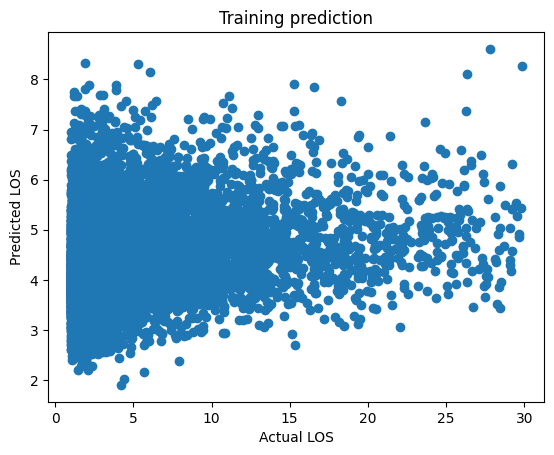

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x=dataY_plot, y=data_predict) #actual plot
plt.ylabel("Predicted LOS")
plt.xlabel("Actual LOS")
plt.title("Training prediction")
#plt.plot(, label='Predicted Data') #predicted plot
#plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(dataY_plot, data_predict)

mae = mean_absolute_error(dataY_plot, data_predict)

print("mse: %1.5f, mae: %1.5f" % (mse, mae))

mse: 19.02976, mae: 2.92072


## Test set prediction

In [ ]:
y_test = np.array(labels_test['los_icu']).reshape(-1,1)
mm = MinMaxScaler()
y_mm_test = mm.fit_transform(y_test)
y_tensors_test = Variable(torch.Tensor(y_mm_test))

In [ ]:
with torch.no_grad():
  lstm_model.eval()
  test_predict = multi_model(static_cat_tensor_test, static_val_tensor_test, timeseries_tensors_test,tfid_tensor_test)#forward pass

data_predict_los, data_pred_mort = test_predict #numpy conversion
data_predict_los=data_predict_los.data.numpy()
dataY_plot = y_tensors_test.data.numpy()

In [ ]:
data_predict_los = mm.inverse_transform(data_predict_los) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

Text(0.5, 1.0, 'Validation set prediction')

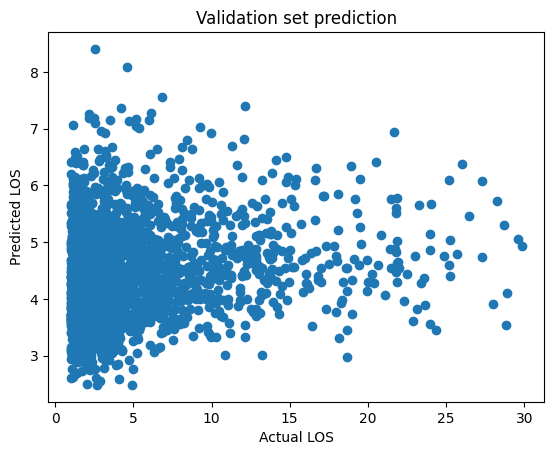

In [ ]:
plt.scatter(x=dataY_plot, y=data_predict_los) #actual plot
plt.ylabel("Predicted LOS")
plt.xlabel("Actual LOS")
plt.title('Validation set prediction')

In [ ]:
mse = mean_squared_error(dataY_plot, data_predict_los)

mae = mean_absolute_error(dataY_plot, data_predict_los)

print("mse: %1.5f, mae: %1.5f" % (mse, mae))

mse: 19.86994, mae: 2.99153


In [ ]:
# #to save
PATH = '/content/gdrive/My Drive/Colab Notebooks/SPH6004/multitasl_lstm.pt'
torch.save(multi_model, PATH)

# #to load
# model = torch.load(PATH)
# model.eval()